### Implementation of logistic regression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
#read dataset
df1 = pd.read_csv('titanic_train.csv', index_col = False)

In [3]:
df1.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [4]:
#convert the column names to lowercase
df1.columns = df1.columns.str.lower()

In [6]:
#drop NaN values
df1 = df1.dropna()

In [48]:
#number of samples per Survival group, 1- survived, 0-not survived
df1.groupby('survived').size()

survived
0     60
1    123
dtype: int64

In [55]:
#taking equal samples (20) from each group
#setting random_state value for reproducibility
df1_sample = df1.groupby('survived').sample(n = 20, random_state = 1)
df1_sample = df1_sample.loc[:,['survived','pclass','sex','age','fare']]

In [56]:
#divide the dataframe into survival categories- 1- survived; 0-not survived
survival_categories = df1_sample.groupby('survived')
#view the keys
survival_categories.groups.keys()

dict_keys([0, 1])

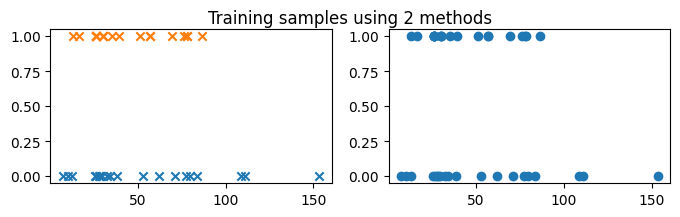

In [57]:
#Plot for the data points
fig, ax = plt.subplots(1, 2, figsize = (8,2))
colors = ('red', 'blue')

for name, group in survival_categories:
    ax[0].scatter(group['fare'], group['survived'], marker = 'x', label = name)

#Subplot 2
ax[1].scatter(df1_sample.loc[:,'fare'], df1_sample.loc[:,'survived'])

fig.suptitle("Training samples using 2 methods")
plt.show()


In [58]:
#selecting relevant columns and dividing into input and target values.
xtrain = df1_sample.loc[:,['pclass','sex','age','fare']]
ytrain = df1_sample.loc[:,'survived']
#Convert Gender column from text to numeric- Male-0, female-1
xtrain['sex_encoded'] = np.where(xtrain['sex'] == "female", 1, 0)

In [59]:
#remove the text gender column
xtrain = xtrain.drop(['sex'], axis = 1)

In [60]:
xtrain.head(5)

,pclass,age,fare,sex_encoded
505,1,18.0,108.9000,0
536,1,45.0,26.5500,0
54,1,65.0,61.9792,0
698,1,49.0,110.8833,0
715,3,19.0,7.6500,0


In [ ]:
# z = np.arange(-20, 20)
# gz = 1/(1 + np.exp(-z))
# np.c_[z, gz]

In [ ]:
# fig, ax = plt.subplots(1, 1, figsize = (5, 3))
# ax.plot(z, gz, c = "red")
# ax.axvline(x = 0, c = "b", ymin = min(gz), ymax = max(gz), linestyle = ":")
# plt.show()

In [ ]:
#sample data to show plot in next chunk
x0 = np.arange(0, 6)
x1 = 3 - x0
np.c_[x0, x1]

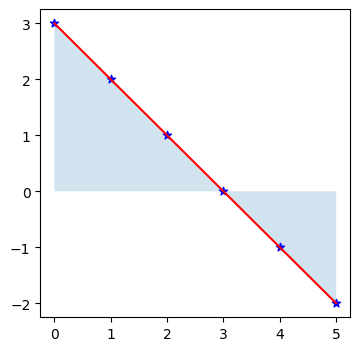

In [21]:
fig, ax = plt.subplots(1,1, figsize = (4,4))
ax.plot(x0, x1, c = "r")
ax.fill_between(x0, x1, alpha= 0.2)
ax.scatter(x0, x1, c = "blue", marker = "*")
plt.show()

In [61]:
#function to compute logistic cost
def compute_log_cost(xtrain, ytrain, w, b, reg_coeff):
    """
    Objective- Compute and return the logistic cost
    Arguments-
    xtrain (2-D matrix)- training samples
    ytrain (1-D array)- target outputs
    w (1-D array)- weights parameter
    b (scalar)- bias
    reg_coeff- regularization coefficient lambda
    """
    m, n = xtrain.shape
    cost = 0.0
    reg = 0.0
    for i in range(m):
        fx = np.dot(xtrain.iloc[i],w) + b
        gz = sigmoid(fx)
        loss = ytrain.iloc[i]*np.log(gz) + (1 - ytrain.iloc[i])*np.log(1 - gz)
        cost = cost + loss
    cost = cost/m
    
    #calculating regularization term
    for j in range(n):
        reg = reg + w[j]**2
    
    reg = reg * (reg_coeff/(2*m))
    total_cost = cost + reg
    return total_cost


In [62]:
#function to compute gradient
def compute_gradient(xtrain, ytrain, w, b):
    m,n = xtrain.shape
    dj_dw = np.zeros(n)
    dj_db = 0.0
    for i in range(m):
        fx = np.dot(xtrain.iloc[i], w) + b
        gz = sigmoid(fx)
        err = gz - ytrain.iloc[i]
        for j in range(n):
            dj_dw[j] = dj_dw[j] + err*xtrain.iloc[i][j]
        dj_db = dj_db + err
    #average
    dj_dw = dj_dw/m
    dj_db = dj_db/m
    return dj_dw, dj_db

In [63]:
def gradient_descent(xtrain, ytrain,w, b, alpha, iters, reg_coeff, compute_cost, compute_gradient):
    w_in, b_in = w, b
    J_history, w_history, b_history = [], [] ,[]
    m,n = xtrain.shape
    #regularization constant.
    reg_term = 1 - alpha*(reg_coeff/m)
    for i in range(iters):
        
        #compute gradient
        dj_dw, dj_db = compute_gradient(xtrain, ytrain, w_in, b_in)
        #simultaneous update
        w_in = w_in*reg_term - alpha*dj_dw
        b_in = b_in - dj_db
        
        #save cost and parameters history
        if i < 100000:
            J_history.append(compute_cost(xtrain, ytrain, w_in, b_in, reg_coeff))
            w_history.append(w_in)
            b_history.append(b_in)
        
    return J_history, w_history, b_history, w_in, b_in

In [64]:
#sigmoid function
def sigmoid(x):
    """
    Objective- compute the sigmoid value of given input
    Argument- x (scalar/1-d array)- training sample(s)
    Returns- scalar/1-d vector of sigmoid values.
    """

    gz = 1/(1 + np.exp(-x))
    
    return gz

In [67]:
#normalize the dataset
def normalize(df):
    """
    Objective- normalize the given dataframe.
    Argument- df (1-d array)
    Return- normalized dataframe, normalizing mean and standard deviation
    """
    norm_mean = np.mean(df, axis = 0)
    norm_sd = np.std(df, axis = 0)
    norm_df = (df - norm_mean)/norm_sd
    
    return norm_mean, norm_sd, norm_df

In [68]:
#Normalizing the dataset-----NaN values returned in age column!!!
norm_mean, norm_sd, norm_xtrain = normalize(xtrain)

In [75]:
#Some other initializations
alpha = 0.00001
lambda_ = 0
w = np.zeros(xtrain.shape[1])
b = 0
iters = 50

In [76]:
#call to gradient descnet
J_history, w_history, b_history, final_w, final_b = gradient_descent(norm_xtrain, ytrain,w, b, 
                                                                     alpha, iters, lambda_, compute_log_cost, compute_gradient)

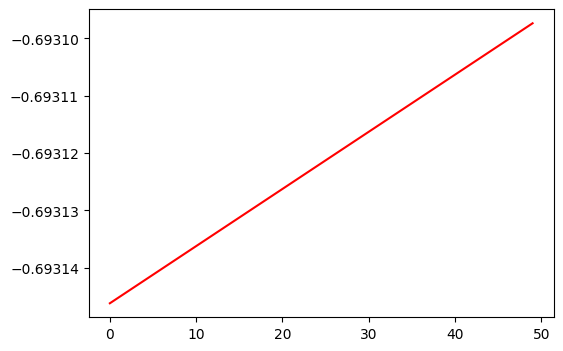

In [80]:
#Learning curve plot
fig, ax = plt.subplots(1,1, figsize = (6,4))

ax.plot(J_history, c = "red")
#ax[1].plot(J_history[80:100], c = "blue")
plt.show()

In [85]:
test_data = pd.read_csv('titanic_test.csv', index_col = False)
#convert columns to lowercase
test_data.columns = test_data.columns.str.lower()
#select relevant columns
test_data = test_data.loc[:,['pclass','sex','age','fare']]
#Convert Gender column from text to numeric- Male-0, female-1
test_data['sex_encoded'] = np.where(test_data['sex'] == "female", 1, 0)

In [ ]:
#select 7 samples and remove the sex column
test_data = test_data[0:7].drop(['sex'], axis = 1)
test_data

In [ ]:
#normalize the test data using norm_mean, norm_sd of training samples
norm_test_data = test_data - norm_mean
norm_test_data = norm_test_data/norm_sd
#display the data
norm_test_data

In [101]:
#take random sample from training dataset to compare model prediction and target
validation_data = df1.groupby('survived').sample(n = 3, random_state = 1)
validation_data = validation_data.loc[:,['survived','pclass','sex','age','fare']]
validation_x = validation_data.loc[:,['pclass','sex','age','fare']]
validation_y = validation_data.loc[:,'survived']
#Convert Gender column from text to numeric- Male-0, female-1
validation_x['sex_encoded'] = np.where(validation_x['sex'] == "female", 1, 0)
#remove the sex column
validation_x = validation_x.drop(['sex'], axis = 1)

In [102]:
#normalize the x data
norm_validx = (validation_x - norm_mean)/norm_sd
norm_validx

In [104]:
#Predict model output
fx = np.dot(norm_validx, final_w) + final_b
gz = sigmoid(fx)


In [105]:
prediction = np.where(gz >=0.5, 1,0)

In [106]:
#printing prediction and target side by side--only 1 mismatch
np.c_[prediction, validation_y]

array([[0, 0],
       [0, 0],
       [0, 0],
       [1, 1],
       [1, 1],
       [0, 1]], dtype=int64)